In [1]:
!pip install xgboost


In [27]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_csv(next(iter(uploaded)))  # use uploaded CSV
df.head()


Saving ML_Water_Quality_Dataset.csv to ML_Water_Quality_Dataset (1).csv


,Distance_Downstream,Day,Nitrate_Concentration,Flow_Rate,Temperature,pH,is_safe
0,0.000000,1,8.248357,1.725886,18.415693,7.152303,0
1,20.202020,1,7.655343,1.733828,18.881455,7.090201,0
2,40.404040,1,7.316576,1.828606,17.860140,6.980282,0
3,60.606061,1,7.457478,1.599683,17.229390,6.983901,0
4,80.808081,1,6.621376,1.838621,17.637837,6.911993,0


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import matplotlib.patches as mpatches
import matplotlib.animation as animation

# Clean theme
sns.set_theme(style="whitegrid", font_scale=1.1)

# --- STEP 1: Regression ---
features = ["Distance_Downstream", "Day", "Flow_Rate", "Temperature", "pH"]
target = "Nitrate_Concentration"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", rmse)
print("R²:", r2_score(y_test, y_pred))


MAE: 0.4604472920691908
RMSE: 0.5848434633067899
R²: 0.9376582087990881


<Figure size 800x400 with 0 Axes>

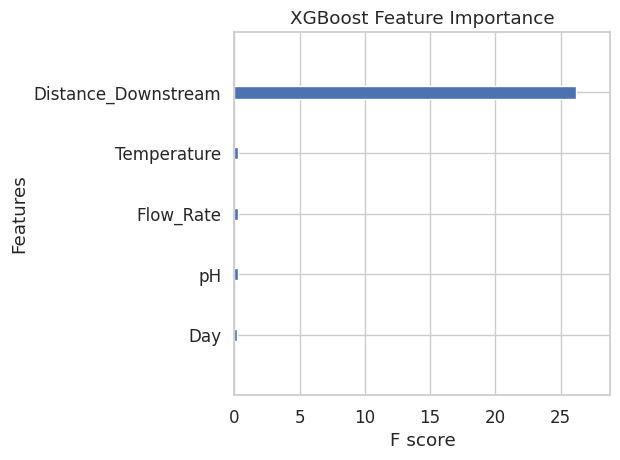

In [29]:

# Feature importance
plt.figure(figsize=(8, 4))
xgb.plot_importance(xgb_model, importance_type='gain', show_values=False)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [30]:
# Z-Score
df["Z_Score"] = (df["Nitrate_Concentration"] - df["Nitrate_Concentration"].mean()) / df["Nitrate_Concentration"].std()
df["Z_Anomaly"] = np.where(abs(df["Z_Score"]) > 2.5, 1, 0)

# Isolation Forest
iso_model = IsolationForest(contamination=0.05, random_state=42)
df["ISO_Anomaly"] = iso_model.fit_predict(X)
df["ISO_Anomaly"] = df["ISO_Anomaly"].map({1: 0, -1: 1})  # convert to 0=normal, 1=anomaly


In [31]:
df_sorted = df.sort_values(by=["Distance_Downstream", "Day"])
df_sorted["Lag_Nitrate"] = df_sorted.groupby("Distance_Downstream")["Nitrate_Concentration"].shift(1)
spatio_df = df_sorted.dropna(subset=["Lag_Nitrate"])


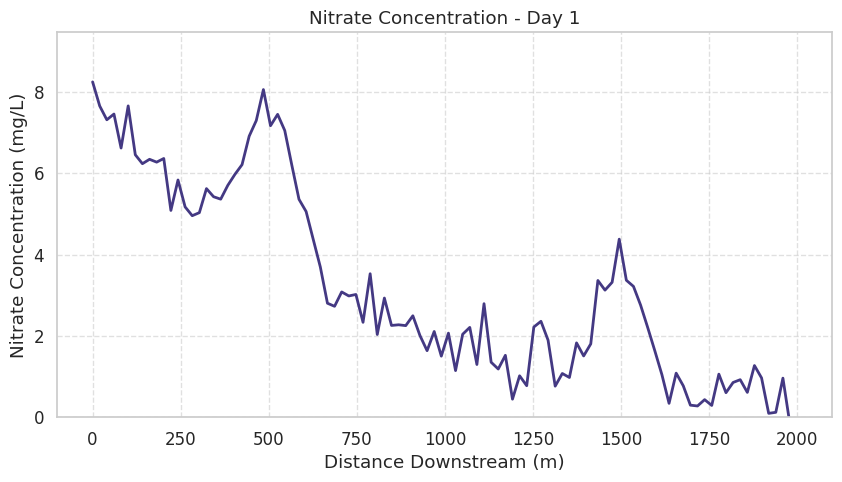

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
days = sorted(df["Day"].unique())
colors = sns.color_palette("viridis", len(days))

def animate(i):
    ax.clear()
    day_data = df[df["Day"] == days[i]]
    ax.plot(day_data["Distance_Downstream"], day_data["Nitrate_Concentration"],
            color=colors[i], linewidth=2)
    ax.set_title(f"Nitrate Concentration - Day {days[i]}")
    ax.set_xlabel("Distance Downstream (m)")
    ax.set_ylabel("Nitrate Concentration (mg/L)")
    ax.set_ylim(0, df["Nitrate_Concentration"].max() + 1)
    ax.grid(True, linestyle="--", alpha=0.6)

ani = animation.FuncAnimation(fig, animate, frames=len(days), interval=1000, repeat=True)

# Show animation (inside Colab)
from IPython.display import HTML
HTML(ani.to_jshtml())
